In [ ]:
import tensorflow as tf
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import os

First, let's create the moons dataset using Scikit-Learn's make_moons() function:

In [ ]:
from  sklearn.datasets  import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

In [ ]:
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negative")
plt.legend()
plt.show()

We must not forget to add an extra bias feature ($x_0 = 1$) to every instance. For this, we just need to add a column full of 1s on the left of the input matrix $\mathbf{X}$

In [ ]:
inputs = np.c_[np.ones((m,1)), X_moons]
output = y_moons

In [ ]:
inputs[:5,]

output is a 1D array but we need to reshape it to a column vector 

In [ ]:
output=output.reshape(-1,1)

Now let's split the data into a training set and a test set:

In [ ]:
def train_test_split(X, y, test_ratio):
    n = X.shape[0]
    test_size = int(n * test_ratio)
    X_train = X[:-test_size]
    X_test = X[-test_size:]
    y_train = y[:-test_size]
    y_test = y[-test_size:]
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(inputs, output, 0.2)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

In [ ]:
X_batch,y_batch = random_batch(X_train, y_train, 5)
X_batch

In [ ]:
reset_graph()

In [ ]:
n_inputs = X_train.shape[1] -1 
X = tf.placeholder(tf.float32, shape=[None, n_inputs+1], name = "x")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform(shape= [n_inputs + 1, 1], minval = -1.0, maxval=1.0), name = "theta")
logits = tf.matmul(X, theta, name="logits")
#predictions = 1/(1+ tf.exp(-logits))
predictions = tf.sigmoid(logits)

#the log loss is a good cost function to use for Logistic Regression
#$J(\mathbf{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}$
#one can use TensorFlow's tf.losses.log_loss() function

loss = tf.losses.log_loss(labels = y, predictions = predictions, weights=1.0, epsilon=1e-07) # uses epsilon = 1e-7 by default
#OR one can implement it oneself:
#epsilon = 1e-7  # to avoid an overflow when computing the log
#loss = -tf.reduce_mean(y * tf.log(y_proba + epsilon) + (1 - y) * tf.log(1 - y_proba + epsilon))
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(m / batch_size))
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            
    predictions_val = predictions.eval(feed_dict={X: X_test, y: y_test})

To classify each instance, we can go for maximum likelihood: classify as positive any instance whose estimated probability is greater or equal to 0.5:

In [ ]:
y_pred  = ( predictions_val >= 0.5)
y_pred[:5]

Depending on the use case, you may want to choose a different threshold than 0.5: make it higher if you want high precision (but lower recall), and make it lower if you want high recall (but lower precision).

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred)

In [ ]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

let's create function for logistic regression

In [1]:
import tensorflow as tf
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

/Users/mustafamuratarat/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import os
from datetime import datetime

In [3]:
reset_graph()

In [4]:
from  sklearn.datasets  import make_moons

num_observations = 1000
X, y = make_moons(num_observations, noise=0.1, random_state=42)

In [5]:
X_enhanced = np.c_[np.ones((num_observations,1)),
                   X,
                   np.square(X[:, 0]),
                   np.square(X[:, 1]),
                   X[:, 0] ** 3,
                   X[:, 1] ** 3]
y=y.reshape(-1,1)

In [6]:
def train_test_split(X, y, test_ratio):
    n = X.shape[0]
    test_size = int(n * test_ratio)
    X_train = X[:-test_size]
    X_test = X[-test_size:]
    y_train = y[:-test_size]
    y_test = y[-test_size:]
    return X_train, X_test, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_enhanced, y, 0.2)

In [8]:
def logistic_regression(X, y, initializer=None, seed = 42, learning_rate = 0.01):
    num_features_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform(shape= [num_features_including_bias, 1], minval = -1.0, maxval=1.0, seed=seed)
            
            theta = tf.Variable(initializer, name = "theta")
            logits = tf.matmul(X, theta, name="logits")
            predictions = tf.sigmoid(logits, name="predictions")
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(labels = y, predictions = predictions, weights=1.0, epsilon=1e-07, scope="loss") # uses epsilon = 1e-7 by default
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    return predictions, loss, training_op, loss_summary, init, saver

In [9]:
def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [10]:
n_inputs = X_train.shape[1]-1
logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

predictions, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [11]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

In [12]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(num_observations / batch_size))

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    predictions = predictions.eval(feed_dict={X: X_test, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.629985
Epoch: 500 	Loss: 0.16122364
Epoch: 1000 	Loss: 0.1190321
Epoch: 1500 	Loss: 0.097329214
Epoch: 2000 	Loss: 0.08369793
Epoch: 2500 	Loss: 0.074375816
Epoch: 3000 	Loss: 0.06750215
Epoch: 3500 	Loss: 0.062206898
Epoch: 4000 	Loss: 0.058026794
Epoch: 4500 	Loss: 0.054562975
Epoch: 5000 	Loss: 0.051708292
Epoch: 5500 	Loss: 0.049237743
Epoch: 6000 	Loss: 0.047167286
Epoch: 6500 	Loss: 0.04537664
Epoch: 7000 	Loss: 0.043818746
Epoch: 7500 	Loss: 0.04237422
Epoch: 8000 	Loss: 0.041089162
Epoch: 8500 	Loss: 0.039970912
Epoch: 9000 	Loss: 0.038920246
Epoch: 9500 	Loss: 0.038010743
Epoch: 10000 	Loss: 0.037155695


In [13]:
y_test_hat = (predictions >= 0.5)

from sklearn.metrics import precision_score, recall_score

print(precision_score(y_test, y_test_hat))
print(recall_score(y_test, y_test_hat))

0.9797979797979798
0.9797979797979798


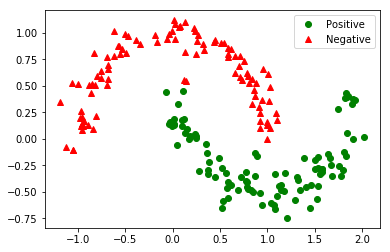

In [18]:
y_pred_idx = y_test_hat.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

In [19]:
!tensorboard --logdir=tf_logs
#http://0.0.0.0:6006/ 

/Users/mustafamuratarat/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
TensorBoard 1.5.1 at http://Arat-MacBook-Pro.local:6006 (Press CTRL+C to quit)
^C
